# Sentiment analysis of Bluesky posts

In [9]:
import pandas as pd
import numpy as np
import snscrape.modules.twitter as sntwitter
from datetime import datetime
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt

## tweets

### load tweets

In [243]:
# loading museum visitor data - field museum??
import glob

path = 'tweets'
filenames = glob.glob(path + "/bristol*.csv")

dfs = []
for f in filenames:
    df = pd.read_csv(f)
    dfs.append(df)

tweets = pd.concat(dfs, ignore_index=True)

# tweets.head()
len(tweets)



6281

### Remove self-tweets by the museum

In [245]:
tweets = tweets[tweets['Handle']!='@bristolmuseum']

print(len(tweets))
tweets.head()


3168


,Name,Handle,Timestamp,Verified,Content,Comments,Retweets,Likes,Analytics,Tags,Mentions,Emojis,Profile Image,Tweet Link,Tweet ID
5,Rhian Rowson,@RhianRowson,2017-12-28T12:32:50.000Z,False,Virginia Woolf's fascination with insect life:...,0,13,24,0,[],['@bristolmuseum'],[],https://pbs.twimg.com/profile_images/606133212...,https://x.com/RhianRowson/status/9463582782163...,tweet_id:946358278216351744
9,RM,@RMAjayi,2017-12-27T12:30:01.000Z,False,"Thanks to a second photo from , I traced 1923 ...",2,1,2,0,[],['@zara_abd'],[],https://pbs.twimg.com/profile_images/971546387...,https://x.com/RMAjayi/status/945995181874171904,tweet_id:945995181874171904
14,Somaliland inBristol,@SLand_inBristol,2017-12-26T14:36:42.000Z,False,Never seen it before but you could approach st...,0,0,0,0,[],[],[],https://pbs.twimg.com/profile_images/731878241...,https://x.com/SLand_inBristol/status/945664672...,tweet_id:945664672040177665
15,Colin Moody,@MoodyColin,2017-12-26T13:54:59.000Z,False,Review of the year. February. Chinese New Year...,0,0,0,0,[],[],[],https://pbs.twimg.com/profile_images/147163090...,https://x.com/MoodyColin/status/94565417608801...,tweet_id:945654176088018945
20,Gary,@Garywalsh_,2017-12-24T21:05:44.000Z,False,absolutely loving the Bristol Museum Christma...,0,0,1,0,[],['@bristolmuseum'],[],https://pbs.twimg.com/profile_images/152847887...,https://x.com/Garywalsh_/status/94503780212276...,tweet_id:945037802122764289


### Plot tweets over time

In [294]:
# now we can plot the number of tweets and the number of visitors

tweets['date'] = pd.to_datetime(tweets['Timestamp']).dt.date

# Summarize total, neutral, positive, and negative tweets by date
tweet_summary_by_date = tweets.groupby('date').agg(
    total_counts=('Content', 'size'),
    neutral_counts=('Sentiment', lambda x: (x == 'neutral').sum()),
    positive_counts=('Sentiment', lambda x: (x == 'positive').sum()),
    negative_counts=('Sentiment', lambda x: (x == 'negative').sum())
).reset_index()

tweet_summary_by_date.head()


,date,total_counts,neutral_counts,positive_counts,negative_counts
0,2015-04-01,5,3,2,0
1,2015-04-02,9,3,0,6
2,2015-04-03,3,0,1,2
3,2015-04-04,2,1,0,1
4,2015-04-05,3,1,2,0


In [247]:
print("There are {} observations and {} features in this dataset. \n".format(tweets.shape[0],tweets.shape[1]))

There are 3168 observations and 16 features in this dataset. 



### make a wordcloud

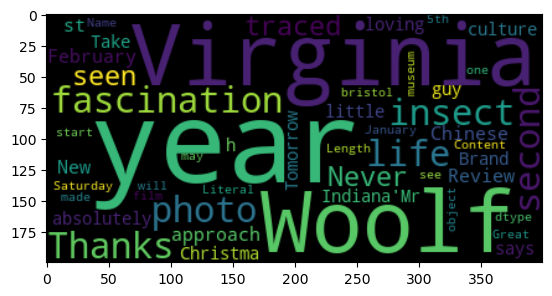

In [248]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = str(tweets['Content'])
# text = str(df.Content)

text = text.replace('Bristol Museum', '')
# text = re.sub('[Nn]atural|[Mm]useum|[Hh]istory', '', text)
# text = re.sub('[Nn]atural', '', text)
# text = re.sub('[Nn]atural', '', text)

wc = WordCloud().generate(text)

plt.imshow(wc, interpolation='bilinear')

plt.savefig('figs/wordcloud.png', dpi=300)


## Do sentiment analysis on tweets



In [195]:
# sentiment analysis functions

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import re

def get_post_sentiment(post):
    # create TextBlob object of passed bluesky post text
    analysis = TextBlob(post)
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

def get_post_sentiment_value(post):
    # create TextBlob object of passed bluesky post text
    analysis = TextBlob(post)
    # set sentiment
    return analysis.sentiment.polarity

def get_post_sentiment_vad(post):
    # create TextBlob object of passed bluesky post text
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(post)
    # set sentiment
    if vs['compound'] > 0:
        return 'positive'
    elif vs['compound'] == 0:
        return 'neutral'
    else:
        return 'negative'

def get_post_sentiment_vad_value(post):
    # create TextBlob object of passed bluesky post text
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(post)
    # set sentiment
    return vs['compound']


In [280]:
def clean_tweets(text):
    return(re.sub(r'http\S+', '', text))

tweets['Content_cleaned'] = tweets['Content'].apply(clean_tweets)

tweets.loc[:, ('Content_cleaned','Content')]

,Content_cleaned,Content
5,Virginia Woolf's fascination with insect life:...,Virginia Woolf's fascination with insect life:...
9,"Thanks to a second photo from , I traced 1923 ...","Thanks to a second photo from , I traced 1923 ..."
14,Never seen it before but you could approach st...,Never seen it before but you could approach st...
15,Review of the year. February. Chinese New Year...,Review of the year. February. Chinese New Year...
20,absolutely loving the Bristol Museum Christma...,absolutely loving the Bristol Museum Christma...
...,...,...
6267,This guy. #Indiana'Mr Brand says he has been h...,This guy. #Indiana'Mr Brand says he has been h...
6270,Take in a little culture while I'm here (at a...,Take in a little culture while I'm here (at a...
6272,"Tomorrow, Saturday 5th January, there will be ...","Tomorrow, Saturday 5th January, there will be ..."
6274,Great to see this in #bristol #museum. Literal...,Great to see this in #bristol #museum. Literal...


In [281]:
tweets['Sentiment'] = tweets['Content_cleaned'].apply(get_post_sentiment)
tweets['Sentiment_value'] = tweets['Content_cleaned'].apply(get_post_sentiment_value)
tweets.head()

# save output
# tweets.to_csv('data/processed/FieldMuseum_2023-03-25_2024-09-11.csv', index=False)

,Name,Handle,Timestamp,Verified,Content,Comments,Retweets,Likes,Analytics,Tags,Mentions,Emojis,Profile Image,Tweet Link,Tweet ID,date,Sentiment,Sentiment_value,month,Content_cleaned
5,Rhian Rowson,@RhianRowson,2017-12-28T12:32:50.000Z,False,Virginia Woolf's fascination with insect life:...,0,13,24,0,[],['@bristolmuseum'],[],https://pbs.twimg.com/profile_images/606133212...,https://x.com/RhianRowson/status/9463582782163...,tweet_id:946358278216351744,2017-12-28,positive,0.425000,2017-12,Virginia Woolf's fascination with insect life:...
9,RM,@RMAjayi,2017-12-27T12:30:01.000Z,False,"Thanks to a second photo from , I traced 1923 ...",2,1,2,0,[],['@zara_abd'],[],https://pbs.twimg.com/profile_images/971546387...,https://x.com/RMAjayi/status/945995181874171904,tweet_id:945995181874171904,2017-12-27,positive,0.050000,2017-12,"Thanks to a second photo from , I traced 1923 ..."
14,Somaliland inBristol,@SLand_inBristol,2017-12-26T14:36:42.000Z,False,Never seen it before but you could approach st...,0,0,0,0,[],[],[],https://pbs.twimg.com/profile_images/731878241...,https://x.com/SLand_inBristol/status/945664672...,tweet_id:945664672040177665,2017-12-26,positive,0.400000,2017-12,Never seen it before but you could approach st...
15,Colin Moody,@MoodyColin,2017-12-26T13:54:59.000Z,False,Review of the year. February. Chinese New Year...,0,0,0,0,[],[],[],https://pbs.twimg.com/profile_images/147163090...,https://x.com/MoodyColin/status/94565417608801...,tweet_id:945654176088018945,2017-12-26,positive,0.068182,2017-12,Review of the year. February. Chinese New Year...
20,Gary,@Garywalsh_,2017-12-24T21:05:44.000Z,False,absolutely loving the Bristol Museum Christma...,0,0,1,0,[],['@bristolmuseum'],[],https://pbs.twimg.com/profile_images/152847887...,https://x.com/Garywalsh_/status/94503780212276...,tweet_id:945037802122764289,2017-12-24,positive,1.000000,2017-12,absolutely loving the Bristol Museum Christma...


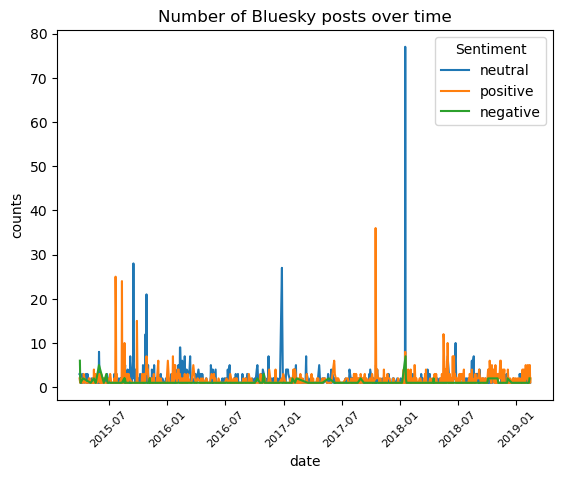

In [282]:
# now plot as a function of time and sentiment:

import seaborn as sns
import pandas as pd

# Summarize number of rows by date and sentiment
summary_by_date = tweets.groupby([tweets['date'], 'Sentiment']).size().reset_index(name='counts')

# are there spikes on museum free days?
# print(summary_by_date.sort_values(by='counts', ascending=False))

# Line plot
sns.lineplot(data=summary_by_date, x='date', y='counts', hue='Sentiment')
plt.xticks(rotation=45, fontsize=8)

# Bar plot
# summary_by_date.pivot(index='date', columns='Sentiment', values='counts').plot(kind='bar', stacked=True)
# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))

plt.xticks(rotation=45, fontsize=8)
plt.title('Number of Bluesky posts over time')

# save figure
plt.savefig('figs/timeline_sentiment_bristol.png', dpi=300)


In [283]:
# summary_by_date.sort_values('counts', ascending=False)
tweets.groupby(tweets['date']).size().sort_values(ascending=False)

date
2018-01-17    85
2017-10-16    38
2015-09-17    29
2016-12-26    29
2015-10-28    28
              ..
2018-01-25     1
2018-01-24     1
2018-01-23     1
2016-08-30     1
2017-04-12     1
Length: 1102, dtype: int64

In [284]:
# Pivot the summary_by_month DataFrame

tweets['date'] = pd.to_datetime(tweets['date'])

# Summarize counts by month
tweets['month'] = tweets['date'].dt.to_period('M')
summary_by_month = tweets.groupby([tweets['month'], 'Sentiment']).size().reset_index(name='counts')
summary_by_month_wide = summary_by_month.pivot(index='month', columns='Sentiment', values='counts').fillna(0)

print(summary_by_month_wide)


Sentiment  negative  neutral  positive
month                                 
2015-04        11.0     36.0      19.0
2015-05         5.0     19.0      26.0
2015-06        10.0     22.0      23.0
2015-07         3.0     24.0      70.0
2015-08         9.0     58.0      64.0
2015-09         2.0     75.0      30.0
2015-10         4.0     86.0      46.0
2015-11         4.0     41.0      24.0
2015-12         3.0     24.0      16.0
2016-01         3.0     37.0      46.0
2016-02         5.0     73.0      43.0
2016-03         2.0     34.0      19.0
2016-04         3.0     26.0      17.0
2016-05         0.0     23.0      20.0
2016-06         2.0     22.0      12.0
2016-07         4.0     26.0      12.0
2016-08         2.0     19.0      19.0
2016-09         3.0     17.0      14.0
2016-10        11.0     39.0      20.0
2016-11         2.0     22.0      16.0
2016-12         1.0     65.0      15.0
2017-01         4.0     23.0      16.0
2017-02         3.0     32.0      34.0
2017-03         1.0     2

In [285]:
# Summarize number of posts by month and filter by negative sentiment
summary_by_month_negative = summary_by_month[summary_by_month['Sentiment'] == 'negative']

# Sort by decreasing counts
summary_by_month_negative_sorted = summary_by_month_negative.sort_values(by='counts', ascending=False)

summary_by_month_negative_sorted.head(10)

,month,Sentiment,counts
98,2018-01,negative,15
0,2015-04,negative,11
53,2016-10,negative,11
6,2015-06,negative,10
12,2015-08,negative,9
107,2018-04,negative,9
104,2018-03,negative,7
128,2018-11,negative,6
101,2018-02,negative,6
131,2018-12,negative,5


In [286]:
# Sort by decreasing counts
summary_by_month_positive = summary_by_month[summary_by_month['Sentiment'] == 'positive']
summary_by_month_positive_sorted = summary_by_month_positive.sort_values(by='counts', ascending=False)

summary_by_month_positive_sorted.head(10)

,month,Sentiment,counts
112,2018-05,positive,85
91,2017-10,positive,76
11,2015-07,positive,70
127,2018-10,positive,66
14,2015-08,positive,64
130,2018-11,positive,58
115,2018-06,positive,49
29,2016-01,positive,46
20,2015-10,positive,46
32,2016-02,positive,43


### Top-10 most "negative" posts

In [288]:
import textwrap

top_neg_posts = list(tweets[tweets['Sentiment'] == 'negative'].sort_values(by='Sentiment_value', ascending=True).head(10)['Content_cleaned'])

# Wrap the text and add new lines
top_neg_posts = [textwrap.fill(post, width=100) for post in top_neg_posts]

print("\n\n".join(top_neg_posts))


 's Grim Reaper finds permanent home at a Bristol museum:  #bristol #Banksy

A mad hatter party on Friday night! — at Bristol Museum & Art Gallery

It's the year of the Dog and you'd be barking mad to miss celebrations Bristol Museum!

 if I can get a ticket im tempted to go on a road trip! I think I queued for about 5/6 hours for
bankys v Bristol museum :(

#Bristol #Job Engagement Officers x 3 - Bristol Museum and Art Gallery - Bristol: (DBS) enhanced
disclos...  #Jobs

#Job #Bath Engagement Officers x 3 - Bristol Museum and Art Gallery - Bristol: (DBS) enhanced
disclosure check...

#Bath #Job Engagement Officers x 3 - Bristol Museum and Art Gallery - Bristol: (DBS) enhanced
disclosure check...

KUTV 2News Family recalls painful internment-camp era as museum opens Bristol…  #museum #news

Anyone fancy this? ,  +++?   The Bad Taste of the Town - Bristol Museum & Art Gallery

At the Bristol museum between 6-9pm jumping over the suspension bridge for Bad Taste of the Town


NB: many of these aren't really negative. I might want to think about training my own word2vec kinda model for predicting sentiments.

### Top-10 most positive posts

In [289]:
import textwrap

# Get the top-10 most positive posts
top_pos_posts = list(tweets[tweets['Sentiment'] == 'positive'].sort_values(by='Sentiment_value', ascending=True).head(10)['Content_cleaned'])

# Wrap the text and add new lines
top_pos_posts = [textwrap.fill(post, width=100) for post in top_pos_posts]

print("\n\n".join(top_pos_posts))


Cheeky little #Banksy in #bristol museum. I was really there seeing Shaun the sheep, but y'know.

It'll be Bassano all the way in 10 days: Curator Dr Jenny Gashke and I share the excitement of
having Leandro's painting back again at Bristol Museum while I link its theme to 'The Eyes that
Look', a novel on another extraordinary Bassano painting, one with an unexplained past.

Except at Bristol Museum where I was more or less forced to 'donate'. Won't be going back.

This Sunday it's Mexican Day of the Dead at Bristol Museum & Art Gallery!  Lots of kid-friendly fun
including...

Tomorrow it's Mexican Day of the Dead at Bristol Museum & Art Gallery!  Lots of kid-friendly fun
including...

ANYONE WANT TO COME TO A FANCY BALL NEXT FRIDAY AT BRISTOL MUSEUM? WILL BE ALL THE FUN (you will be
sat with me though. Not sure if this is a selling point or a reason not to go).

Bath planning another Grayson Perry exhibition because apparently the recent Cirencester, Victoria
Art Gallery, Arnolfini an

I want to check this out more closely. Some of these tweets are NOT positive.

## Load the daily visitor data

{'M Shed', 'The Red Lodge Museum', 'ROMAN-VILLA', 'Bristol Archives', 'Bristol Museum', 'Blaise Castle House Museum', 'The Georgian House Museum'}
1379


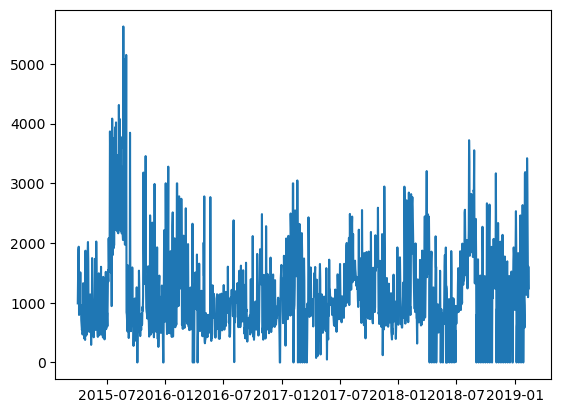

In [290]:
# loading museum visitor data - bristol museum
# https://opendata.bristol.gov.uk/datasets/98d95d36536343eca59e6e4bb04c58b7_0/explore

df2 = pd.read_csv('data/raw/Bristol_Museums_Daily_Visitor_Numbers.csv')

print(set(df2['Museum']))

df2 = df2[df2['Museum'] == 'Bristol Museum']

df2['Date'] = pd.to_datetime(df2['Date']).dt.date
# df2['date'] = df2['Date'].dt.date

df2.sort_values('Date', inplace=True)

print(len(df2))

# plt.scatter(df2['Date'], df2['Number_of_visitors'])

plt.plot(df2['Date'], df2['Number_of_visitors'])

# df2['Number_of_visitors'].groupby('Museum').aggregate(['min', 'max', 'mean', 'std'])
# df2.groupby('Museum').sum()


## merge visitor data and tweets

In [295]:
# Merge with visitor data
merged_data = pd.merge(df2, tweet_summary_by_date, left_on='Date', right_on='date', how='left')
# merged_data.head()

merged_data['date'] = pd.to_datetime(merged_data['date'])

merged_data['day'] = merged_data['date'].dt.day_name()

merged_data['weekend'] = [True if x in ['Saturday', 'Sunday'] else False for x in merged_data['day']]

merged_data.head()

,Museum,Kpi,Number_of_visitors,Date,Comments,Date_Logged,ObjectId,date,total_counts,neutral_counts,positive_counts,negative_counts,day,weekend
0,Bristol Museum,visits,990.0,2015-04-01,NaN,2017/05/10 14:50:55.376+00,6854,2015-04-01,5.0,3.0,2.0,0.0,Wednesday,False
1,Bristol Museum,visits,1452.0,2015-04-02,NaN,2017/05/10 14:50:55.380+00,6848,2015-04-02,9.0,3.0,0.0,6.0,Thursday,False
2,Bristol Museum,visits,1894.0,2015-04-03,NaN,2017/05/10 14:50:55.384+00,6842,2015-04-03,3.0,0.0,1.0,2.0,Friday,False
3,Bristol Museum,visits,1939.0,2015-04-04,NaN,2017/05/10 14:50:55.387+00,6836,2015-04-04,2.0,1.0,0.0,1.0,Saturday,True
4,Bristol Museum,visits,796.0,2015-04-05,NaN,2017/05/10 14:50:55.391+00,6830,2015-04-05,3.0,1.0,2.0,0.0,Sunday,True


In [296]:
# Plot the number of tweets and the number of visitors
# merged_data_2018 = merged_data[(merged_data['date'].dt.year == 2018) & (merged_data['weekend'] == True)]
merged_data_2018 = merged_data[merged_data['date'].dt.year == 2018]
merged_data_2018

,Museum,Kpi,Number_of_visitors,Date,Comments,Date_Logged,ObjectId,date,total_counts,neutral_counts,positive_counts,negative_counts,day,weekend
981,Bristol Museum,visits,632.0,2018-01-01,NaN,2018/01/13 12:58:00.747+00,1522,2018-01-01,1.0,1.0,0.0,0.0,Monday,False
982,Bristol Museum,visits,1458.0,2018-01-02,NaN,2018/01/13 12:57:41.220+00,1516,2018-01-02,2.0,1.0,0.0,1.0,Tuesday,False
983,Bristol Museum,visits,1087.0,2018-01-03,NaN,2018/01/13 12:57:21.019+00,1505,2018-01-03,3.0,2.0,1.0,0.0,Wednesday,False
984,Bristol Museum,visits,891.0,2018-01-04,NaN,2018/01/13 12:56:46.745+00,1497,2018-01-04,2.0,1.0,1.0,0.0,Thursday,False
985,Bristol Museum,visits,866.0,2018-01-05,NaN,2018/01/13 12:55:18.019+00,1489,2018-01-05,1.0,1.0,0.0,0.0,Friday,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,Bristol Museum,visits,0.0,2018-12-26,NaN,2019/02/12 12:20:29.169+00,59,2018-12-26,2.0,1.0,1.0,0.0,Wednesday,False
1330,Bristol Museum,visits,1206.0,2018-12-27,NaN,2018/12/30 14:51:24.702+00,58,2018-12-27,1.0,1.0,0.0,0.0,Thursday,False
1331,Bristol Museum,visits,1715.0,2018-12-28,NaN,2018/12/30 14:50:50.236+00,55,2018-12-28,2.0,0.0,2.0,0.0,Friday,False
1332,Bristol Museum,visits,1927.0,2018-12-29,NaN,2018/12/30 14:50:13.348+00,51,2018-12-29,3.0,1.0,2.0,0.0,Saturday,True


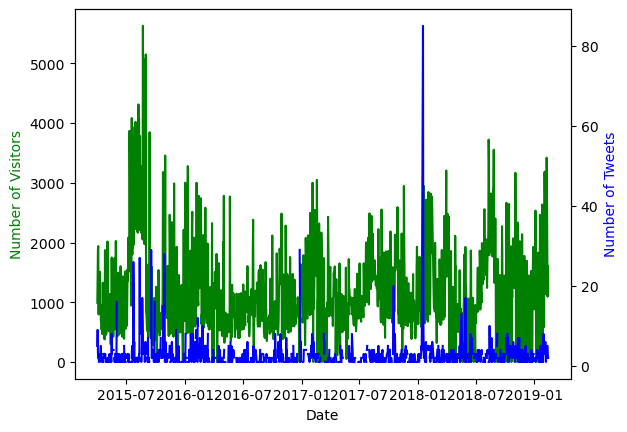

In [298]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(merged_data['Date'], merged_data['Number_of_visitors'], 'g-')
ax2.plot(merged_data['Date'], merged_data['total_counts'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Visitors', color='g')
ax2.set_ylabel('Number of Tweets', color='b')

plt.show()

# spikey- are those weekends?



<Axes: xlabel='Number_of_visitors', ylabel='counts'>

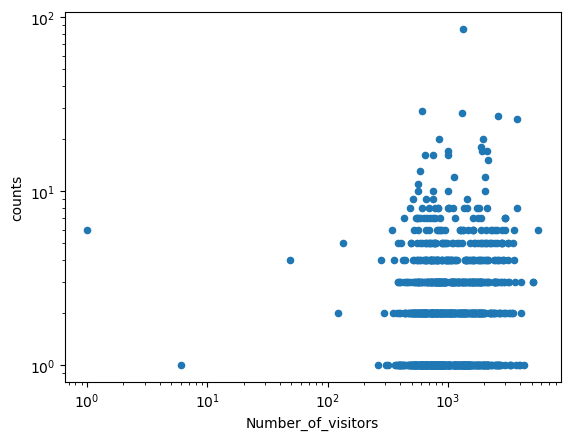

In [238]:
merged_data_clim.plot(x='Number_of_visitors', y='counts', kind='scatter', loglog=True)

In [239]:
# See what's causing the big spike in Jan. 2018
merged_data.sort_values('counts', ascending=False)
# merged_data.head()

,Museum,Kpi,Number_of_visitors,Date,Comments,Date_Logged,ObjectId,date,counts,day,weekend
993,Bristol Museum,visits,1342.0,2018-01-17,the counter stopped at 4pm,2018/01/20 14:48:26.611+00,1408,2018-01-17,85.0,Wednesday,False
167,Bristol Museum,visits,607.0,2015-09-17,NaN,2017/05/10 14:50:56.010+00,5842,2015-09-17,29.0,Thursday,False
634,Bristol Museum,visits,0.0,2016-12-26,NaN,2017/05/10 14:50:57.757+00,2839,2016-12-26,29.0,Monday,False
208,Bristol Museum,visits,1315.0,2015-10-28,NaN,2017/05/10 14:50:56.163+00,5760,2015-10-28,28.0,Wednesday,False
131,Bristol Museum,visits,2627.0,2015-08-12,NaN,2017/05/10 14:50:55.875+00,6154,2015-08-12,27.0,Wednesday,False
...,...,...,...,...,...,...,...,...,...,...,...
1342,Bristol Museum,visits,0.0,2019-01-07,NaN,2019/02/12 12:22:44.769+00,174,NaT,NaN,NaN,False
1344,Bristol Museum,visits,693.0,2019-01-09,NaN,2019/01/12 12:05:37.022+00,171,NaT,NaN,NaN,False
1348,Bristol Museum,visits,1539.0,2019-01-13,NaN,2019/01/20 09:31:30.978+00,163,NaT,NaN,NaN,False
1350,Bristol Museum,visits,895.0,2019-01-15,NaN,2019/01/29 14:19:43.615+00,159,NaT,NaN,NaN,False


In [204]:
# tweets[tweets['date'] == '2018-01-17']
# tweets

merged_data.to_csv('data/processed/bristol_museum_tweets_visitors.csv', index=False)

# TODO: maybe start the script here, and put all the stuff above into a processing py script

In [241]:
from datetime import datetime as dt

start_date = dt.strptime('2018-01-17', '%Y-%m-%d').date()
end_date = dt.strptime('2018-01-17', '%Y-%m-%d').date()
# end_date = '2018-01-31'

filtered_tweets = tweets[(tweets['date'] >= start_date) & (tweets['date'] <= end_date)]

# Seems that the museum sold a Banksy print without that rights and that caused the spike in tweets that day
set(filtered_tweets['Content'])



{'  #fdlx #Bristol Museum sold unauthorised Banksy angel prints #News',
 ' Good Morning Bristol Museum! We love suggesting attractions to visit & would love it if you could follow us back. ',
 '#Bristol #Museum sold unauthorised #Banksy angel prints http://bbc.co.uk/news/uk-england-bristol-42708000…',
 'A #Bristol museum which produced prints of this #Banksy artwork, and sold more than 1,000 in a day, did not have permission to do so.\n\nMORE: http://bbc.in/2mECl9y',
 'BBC News - Bristol Museum sold unauthorised Banksy angel prints http://bbc.co.uk/news/uk-england-bristol-42708000…',
 'BBC News - Bristol Museum sold unauthorised Banksy prints http://bbc.co.uk/news/uk-england-bristol-42708000… - an object lesson in why galleries need to sort out their permissions in advance',
 'BBC News Bristol Museum sold unauthorised Banksy angel prints BBC News A… https://goo.gl/fb/qirmJJ #museum #news',
 'BBC News reporting that The Bristol Museum has been selling unauthorised prints of a Banksy scu

## Weather data

In [242]:
# Get weather data
from meteostat import Point, Daily
from datetime import datetime
import matplotlib.pyplot as plt



# Set time period
start = datetime(2014, 1, 1)
end = datetime(2019, 12, 31)

lat = 51.454514
lon = -2.587910
alt = 36 # feet

# Create Point for Bristol
bristol = Point(lat, lon, alt)

# Get daily data for 2014-2019
data = Daily(bristol, start, end)
data = data.fetch()

data.to_csv('data/processed/climate_bristol.csv')

# lyneham has precipitation data-
data = Daily('03740', start, end)
data = data.fetch()
data.head()

data.to_csv('data/processed/climate_lyneham.csv')


ModuleNotFoundError: No module named 'meteostat'

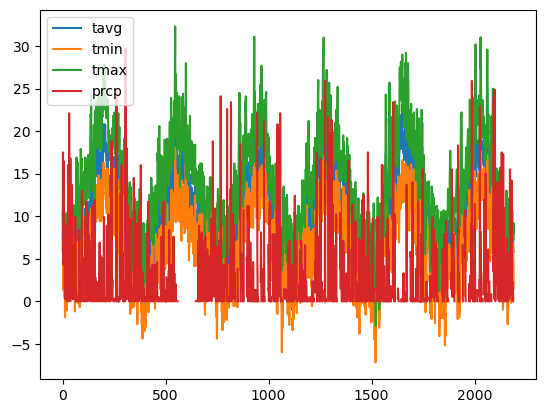

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

climdat = pd.read_csv('data/processed/climate_lyneham.csv')

# Plot line chart including average, minimum and maximum temperature
climdat.plot(y=['tavg', 'tmin', 'tmax','prcp'])
plt.show()


In [40]:
# add weather data to the merged data
# Convert 'time' column to datetime
climdat['time'] = pd.to_datetime(climdat['time']).dt.date
climdat['time']



0       2014-01-01
1       2014-01-02
2       2014-01-03
3       2014-01-04
4       2014-01-05
           ...    
2186    2019-12-27
2187    2019-12-28
2188    2019-12-29
2189    2019-12-30
2190    2019-12-31
Name: time, Length: 2191, dtype: object

In [324]:
# Merge weather data with the merged_data DataFrame
merged_data_clim = pd.merge(merged_data, climdat, left_on='Date', right_on='time', how='left')

merged_data_clim.head()

,Museum,Kpi,Number_of_visitors,Date,Comments,Date_Logged,ObjectId,date,total_counts,neutral_counts,...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,Bristol Museum,visits,990.0,2015-04-01,NaN,2017/05/10 14:50:55.376+00,6854,2015-04-01,5.0,3.0,...,6.3,2.6,9.9,0.5,NaN,268.0,25.0,NaN,1023.8,NaN
1,Bristol Museum,visits,1452.0,2015-04-02,NaN,2017/05/10 14:50:55.380+00,6848,2015-04-02,9.0,3.0,...,7.9,5.2,9.8,1.5,NaN,225.0,14.1,NaN,1020.6,NaN
2,Bristol Museum,visits,1894.0,2015-04-03,NaN,2017/05/10 14:50:55.384+00,6842,2015-04-03,3.0,0.0,...,9.0,7.3,12.1,1.5,NaN,243.0,11.9,NaN,1016.5,NaN
3,Bristol Museum,visits,1939.0,2015-04-04,NaN,2017/05/10 14:50:55.387+00,6836,2015-04-04,2.0,1.0,...,7.4,6.0,8.9,4.6,NaN,18.0,16.0,NaN,1023.0,NaN
4,Bristol Museum,visits,796.0,2015-04-05,NaN,2017/05/10 14:50:55.391+00,6830,2015-04-05,3.0,1.0,...,8.8,5.5,12.4,0.0,NaN,25.0,8.1,NaN,1027.2,NaN


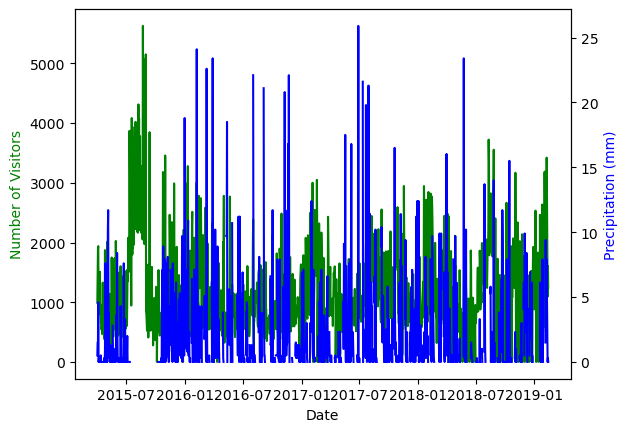

In [325]:
# Plot precipitation and visits

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(merged_data_clim['Date'], merged_data_clim['Number_of_visitors'], 'g-')
ax2.plot(merged_data_clim['Date'], merged_data_clim['prcp'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Visitors', color='g')
ax2.set_ylabel('Precipitation (mm)', color='b')

plt.show()

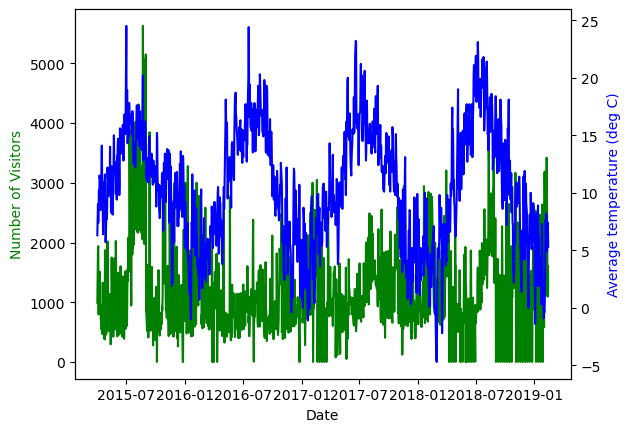

In [326]:
# Plot average temperature and museum visits

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(merged_data_clim['Date'], merged_data_clim['Number_of_visitors'], 'g-')
ax2.plot(merged_data_clim['Date'], merged_data_clim['tavg'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Visitors', color='g')
ax2.set_ylabel('Average temperature (deg C)', color='b')

plt.show()

## Random forest regression modeling

In [328]:
# what other predictors?
# i want to make a predictive model of future trends 

# what about holidays?

# what about weekends?

# what about school holidays? NOT SURE

# what about special events?

# what about unique exhibitions?

# what about marketing campaigns?

# what about twitter sentiment? (might need to account for a lag here)

# what about the weather?
# DONE

# what about the day of the week?
print(set(merged_data_clim['day']))

# what about the month?
merged_data_clim['month'] = merged_data_clim['date'].dt.month
print(set(merged_data_clim['month']))

# what about the year?
merged_data_clim['year'] = merged_data_clim['date'].dt.year

# what about the season?
# winter: December to February
# spring: March to May
# summer: June to August
# autumn: September to November
merged_data_clim['season'] = pd.cut(merged_data_clim['month'], bins=[0, 3, 6, 9, 12], labels=['winter', 'spring', 'summer', 'autumn'])

merged_data_clim.head()

{'Tuesday', 'Thursday', 'Monday', nan, 'Sunday', 'Saturday', 'Wednesday', 'Friday'}
{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

,Museum,Kpi,Number_of_visitors,Date,Comments,Date_Logged,ObjectId,date,total_counts,neutral_counts,...,prcp,snow,wdir,wspd,wpgt,pres,tsun,year,month,season
0,Bristol Museum,visits,990.0,2015-04-01,NaN,2017/05/10 14:50:55.376+00,6854,2015-04-01,5.0,3.0,...,0.5,NaN,268.0,25.0,NaN,1023.8,NaN,2015.0,4.0,spring
1,Bristol Museum,visits,1452.0,2015-04-02,NaN,2017/05/10 14:50:55.380+00,6848,2015-04-02,9.0,3.0,...,1.5,NaN,225.0,14.1,NaN,1020.6,NaN,2015.0,4.0,spring
2,Bristol Museum,visits,1894.0,2015-04-03,NaN,2017/05/10 14:50:55.384+00,6842,2015-04-03,3.0,0.0,...,1.5,NaN,243.0,11.9,NaN,1016.5,NaN,2015.0,4.0,spring
3,Bristol Museum,visits,1939.0,2015-04-04,NaN,2017/05/10 14:50:55.387+00,6836,2015-04-04,2.0,1.0,...,4.6,NaN,18.0,16.0,NaN,1023.0,NaN,2015.0,4.0,spring
4,Bristol Museum,visits,796.0,2015-04-05,NaN,2017/05/10 14:50:55.391+00,6830,2015-04-05,3.0,1.0,...,0.0,NaN,25.0,8.1,NaN,1027.2,NaN,2015.0,4.0,spring


In [329]:
# do time series analysis?

# print(merged_data_clim.info())

merged_data_clim.columns

Index(['Museum', 'Kpi', 'Number_of_visitors', 'Date', 'Comments',
       'Date_Logged', 'ObjectId', 'date', 'total_counts', 'neutral_counts',
       'positive_counts', 'negative_counts', 'day', 'weekend', 'time', 'tavg',
       'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun',
       'year', 'month', 'season'],
      dtype='object')

### Clean the data set (remove NAs, etc)

In [356]:
# Select relevant variables and drop NAs
selected_columns = ['date', 'Number_of_visitors', 'positive_counts', 'negative_counts', 'neutral_counts', 'day', 'season', 'weekend', 'tavg', 'prcp']
# cleaned_data = merged_data_clim[selected_columns]
cleaned_data = merged_data_clim[selected_columns].dropna()
cleaned_data.head()

,date,Number_of_visitors,positive_counts,negative_counts,neutral_counts,day,season,weekend,tavg,prcp
0,2015-04-01,990.0,2.0,0.0,3.0,Wednesday,spring,False,6.3,0.5
1,2015-04-02,1452.0,0.0,6.0,3.0,Thursday,spring,False,7.9,1.5
2,2015-04-03,1894.0,1.0,2.0,0.0,Friday,spring,False,9.0,1.5
3,2015-04-04,1939.0,0.0,1.0,1.0,Saturday,spring,True,7.4,4.6
4,2015-04-05,796.0,2.0,0.0,1.0,Sunday,spring,True,8.8,0.0


In [357]:
cleaned_data = pd.get_dummies(cleaned_data, columns=['season','day'])
cleaned_data

,date,Number_of_visitors,positive_counts,negative_counts,neutral_counts,weekend,tavg,prcp,season_winter,season_spring,season_summer,season_autumn,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,2015-04-01,990.0,2.0,0.0,3.0,False,6.3,0.5,False,True,False,False,False,False,False,False,False,False,True
1,2015-04-02,1452.0,0.0,6.0,3.0,False,7.9,1.5,False,True,False,False,False,False,False,False,True,False,False
2,2015-04-03,1894.0,1.0,2.0,0.0,False,9.0,1.5,False,True,False,False,True,False,False,False,False,False,False
3,2015-04-04,1939.0,0.0,1.0,1.0,True,7.4,4.6,False,True,False,False,False,False,True,False,False,False,False
4,2015-04-05,796.0,2.0,0.0,1.0,True,8.8,0.0,False,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,2019-02-09,3421.0,1.0,1.0,0.0,True,6.2,7.9,True,False,False,False,False,False,True,False,False,False,False
1375,2019-02-10,2843.0,5.0,0.0,0.0,True,4.9,5.3,True,False,False,False,False,False,False,True,False,False,False
1376,2019-02-12,1094.0,5.0,0.0,0.0,False,5.8,0.0,True,False,False,False,False,False,False,False,False,True,False
1377,2019-02-13,1606.0,1.0,0.0,1.0,False,7.4,0.3,True,False,False,False,False,False,False,False,False,False,True


### Partition the data into training and test data sets

In [358]:
from sklearn.model_selection import train_test_split

# Randomly split 20% of rows as testing (or validation) and the other as training
train_data, test_data = train_test_split(cleaned_data, test_size=0.2, random_state=42)
len(train_data), len(test_data)

(551, 138)

In [359]:
# Selecting columns for regressions
X_train = train_data.drop(columns=['date', 'Number_of_visitors'])
y_train = train_data['Number_of_visitors']

X_test = test_data.drop(columns=['date', 'Number_of_visitors'])
y_test = test_data['Number_of_visitors']


### Fit a decision tree regressor model

In [360]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

# Do decision tree regression
dtree = DecisionTreeRegressor(max_depth=5, min_samples_leaf=0.13, random_state=3)
dtree.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=5, min_samples_leaf=0.13, random_state=3)

In [361]:
# Output R2, MSE for training and testing data-

# training data
pred_train_tree= dtree.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_tree)))
print(r2_score(y_train, pred_train_tree))

# validation/testing data
pred_test_tree= dtree.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_tree))) 
print(r2_score(y_test, pred_test_tree))


535.8961803064384
0.36879984294103463
572.2669819215824
0.23328323664667638


### Fit a random forest regression model

In [362]:
model_rf = RandomForestRegressor(n_estimators=5000, oob_score=True, random_state=100, max_depth = None)
model_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=5000, oob_score=True, random_state=100)

In [390]:
# extract R2, model fits
pred_train_rf= model_rf.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print(r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print(r2_score(y_test, pred_test_rf))

200.5079921546526
0.9116372646636169
556.3586542397204
0.27531833029311625


$R^2$ = 91.2% - not bad?? But $R^2$ for the test data is rather low at ~27.5%. I probably need to take a look at what's going on there.

#### Plot the predicted and actual number of visitors for the RF model

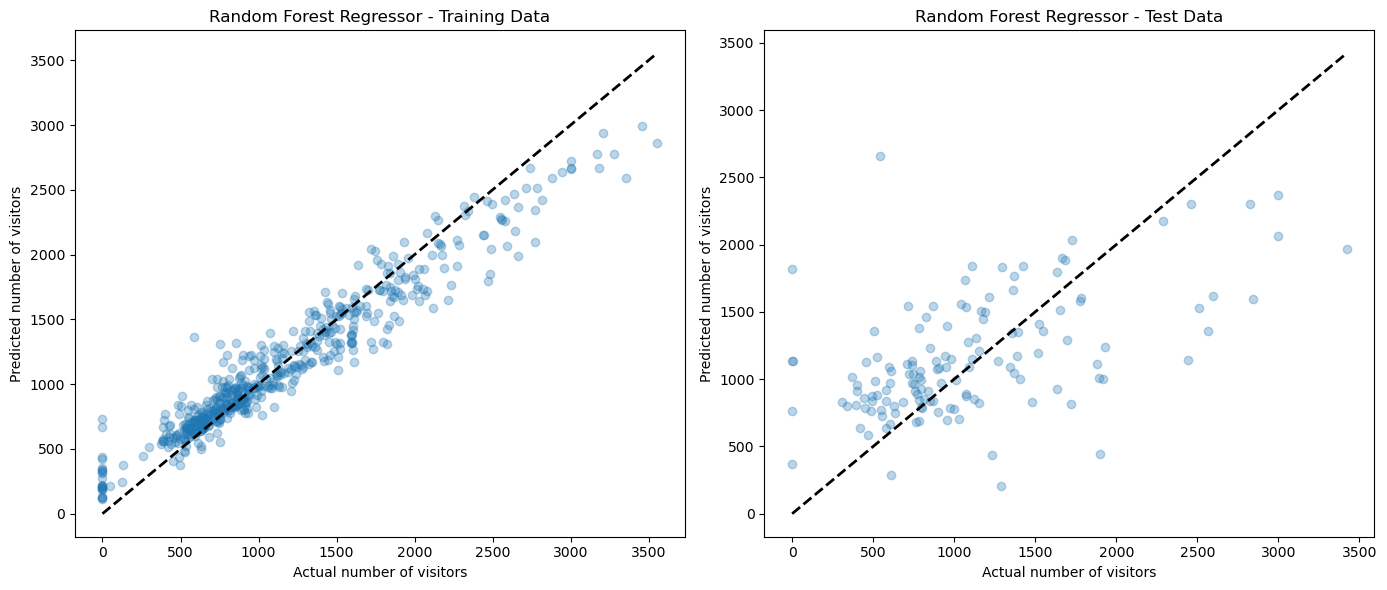

In [364]:

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, pred_train_rf, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel('Actual number of visitors')
plt.ylabel('Predicted number of visitors')
plt.title('Random Forest Regressor - Training Data')

# Plotting the test data predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test, pred_test_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual number of visitors')
plt.ylabel('Predicted number of visitors')
plt.title('Random Forest Regressor - Test Data')

plt.tight_layout()
plt.show()

#### Look at RF decision tree

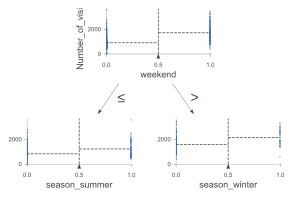

In [423]:
from sklearn import tree

# Get the feature names
feature_names = X_train.columns

# Pick the first tree from the forest
dtree1 = model_rf.estimators_[1]

# Plot the tree
# plt.figure(figsize=(30, 20))
# tree.plot_tree(dtree1, feature_names=feature_names, max_depth=5, filled=True, node_ids=True, rounded=True)
# plt.show()


# Another way

m = dtreeviz.model(dtree1, X_train, y_train, feature_names=feature_names, target_name='Number_of_visitors')
m.view(depth_range_to_display=[0,1,2,3,4])



In [384]:
# try this shit out

import dtreeviz

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

clf = DecisionTreeClassifier(max_depth=4)

clf.fit(X_train, y_train_encoded)

# tmp = dtreeviz.model(clf, X_train, y_train_encoded)

# tmp.view(scale=1.2)

# viz_model = dtreeviz.model(clf,
#                            X_train=X_train, y_train=y_train)

# viz_model.view(scale=1.2)


DecisionTreeClassifier(max_depth=4)

#### Get feature importances

In [385]:
importances = model_rf.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

            Feature  Importance
3           weekend    0.286799
4              tavg    0.197610
5              prcp    0.152240
2    neutral_counts    0.068804
0   positive_counts    0.065495
6     season_winter    0.042386
8     season_summer    0.034778
1   negative_counts    0.024355
11       day_Monday    0.023431
12     day_Saturday    0.022943
7     season_spring    0.019991
13       day_Sunday    0.013817
9     season_autumn    0.013431
15      day_Tuesday    0.010186
16    day_Wednesday    0.008827
14     day_Thursday    0.007573
10       day_Friday    0.007333


In [386]:
merged_data_clim['Number_of_visitors'].max()
# max number of visitors on a day

5628.0

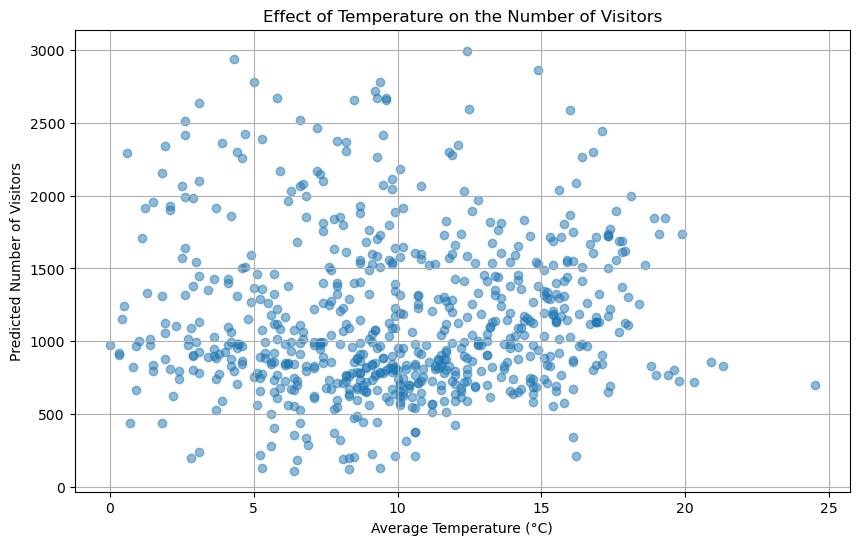

In [387]:
# Extract the temperature feature and the predicted number of visitors
temperature = cleaned_data['tavg']
predicted_visitors = model_rf.predict(cleaned_data.drop(columns=['date', 'Number_of_visitors']))

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(temperature, predicted_visitors, alpha=0.5)
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Predicted Number of Visitors')
plt.title('Effect of Temperature on the Number of Visitors')
plt.grid(True)
plt.show()

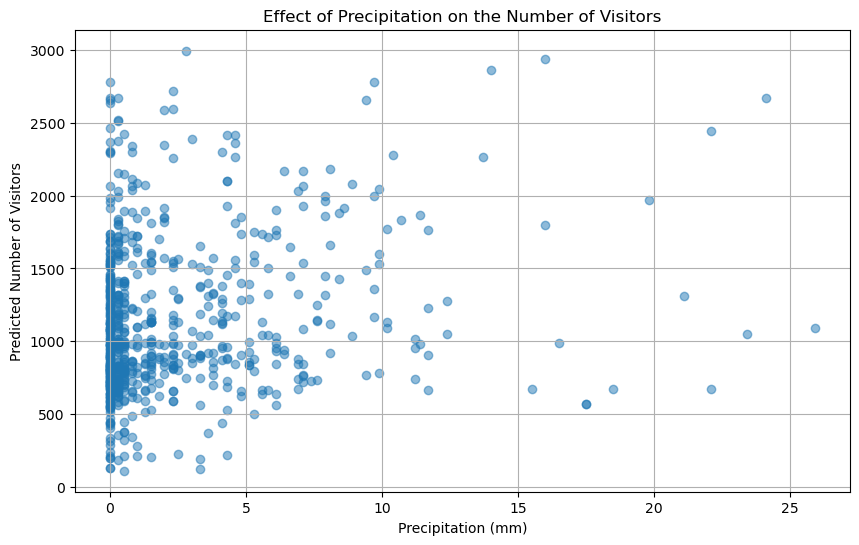

In [388]:
# this temp effect doesn't seem that strong
# maybe we need to look at the interaction between temp and other variables

# Extract the precipitation feature and the predicted number of visitors
precipitation = cleaned_data['prcp']
predicted_visitors = model_rf.predict(cleaned_data.drop(columns=['date', 'Number_of_visitors']))

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(precipitation, predicted_visitors, alpha=0.5)
plt.xlabel('Precipitation (mm)')
plt.ylabel('Predicted Number of Visitors')
plt.title('Effect of Precipitation on the Number of Visitors')
plt.grid(True)
plt.show()


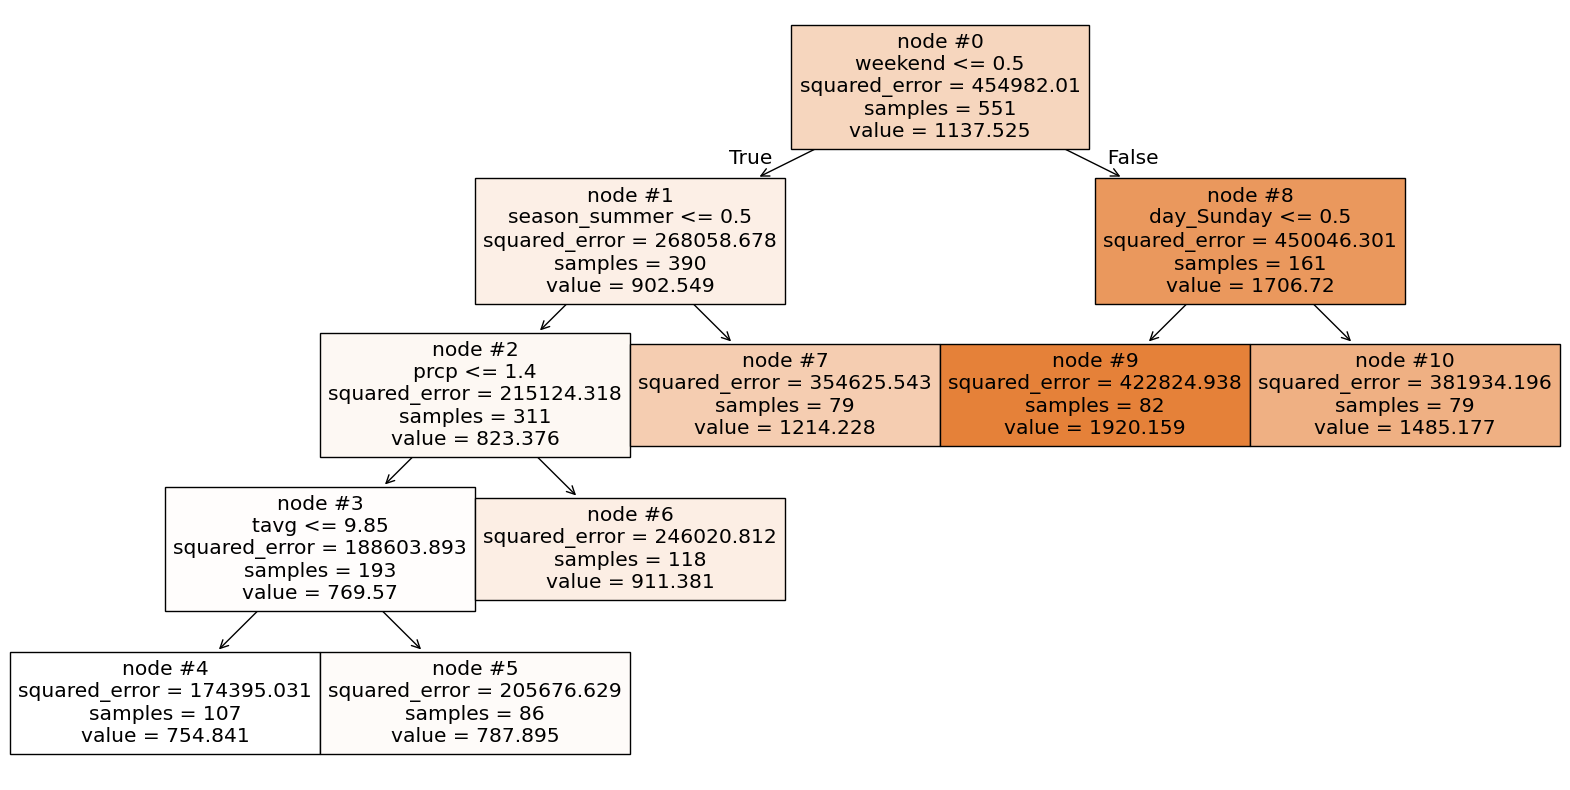

In [389]:
from sklearn import tree

import matplotlib.pyplot as plt

# Get the feature names
feature_names = X_train.columns

# Find the indices of the nodes that involve the 'prcp' feature
prcp_indices = [x == 'prcp' for x in feature_names]
# prcp_indices


# Plot the tree with only the nodes involving 'prcp'
plt.figure(figsize=(20, 10))
tree.plot_tree(dtree, feature_names=feature_names, max_depth=5, filled=True, node_ids=True)
plt.show()